In [1]:
%env TF_USE_LEGACY_KERAS=0

env: TF_USE_LEGACY_KERAS=0


In [ ]:
import pandas as pd
import os
import numpy as np
import matplotlib
from IPython.display import Image
import tensorflow as tf
import tf_keras as keras
import tensorflow_hub as hub
from sklearn.model_selection import train_test_split
from matplotlib.pyplot import imread
import matplotlib.pyplot as plt
print("TF Version: " + tf.__version__)
print("TF hub Version: " + hub.__version__)


TF Version: 2.18.0
TF hub Version: 0.16.1


In [4]:
MAX_FILE_SIZE = 40
IMG_SIZE = 64
colors = ["x", "bg"]

if (not os.path.exists("patches/")):
  os.makedirs("patches/")

for id in range(MAX_FILE_SIZE*2):
    local_idx = id % MAX_FILE_SIZE
    color_idx = id // MAX_FILE_SIZE
    name = colors[color_idx] + str(local_idx+1)
    path = "images/" + name + ".jpg"
    
    image = tf.io.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.convert_image_dtype(image,tf.float32)
    image = tf.image.resize(image, (IMG_SIZE*3, IMG_SIZE*3))
    image = tf.constant(tf.expand_dims(image, axis=0))

    left = 0.05
    right = 0.85
    crop_boxes = [[0, left, 1.0, right]]
    image = tf.image.crop_and_resize(image, crop_boxes, [0], [IMG_SIZE*3, IMG_SIZE*3])

    image = tf.image.extract_patches(
      image,
      sizes=(1, IMG_SIZE, IMG_SIZE, 1),
      strides=[1, IMG_SIZE, IMG_SIZE, 1],
      rates=[1, 1, 1, 1],
      padding='VALID')
    image = tf.reshape(image, [1, 9, IMG_SIZE, IMG_SIZE, 3])

    for sub in range(9):
      new_name = colors[color_idx] + str(local_idx*9 + sub)
      out_path = "patches/" + new_name + ".jpg"
      out = image[0][sub]
      out = tf.image.adjust_contrast(out, 2.0)
      out = tf.image.adjust_saturation(out, 0.0)
      out = tf.image.convert_image_dtype(out,tf.uint8)
      encoded = tf.image.encode_jpeg(out, format="rgb")
      
      tf.io.write_file(out_path, encoded)
  

In [12]:
MAX_FILE_SIZE = 40*9
def mapper(id):
    local_idx = id % MAX_FILE_SIZE
    color_idx = id // MAX_FILE_SIZE
    name = colors[color_idx] + str(local_idx)
    label = colors[color_idx]
    return ["patches/" + name + ".jpg", label]

data = list(map(mapper, iter(range(0, MAX_FILE_SIZE*2))))
labels = pd.DataFrame(data, columns=["path", "label"])
labels

,path,label
0,patches/x0.jpg,x
1,patches/x1.jpg,x
2,patches/x2.jpg,x
3,patches/x3.jpg,x
4,patches/x4.jpg,x
...,...,...
715,patches/bg355.jpg,bg
716,patches/bg356.jpg,bg
717,patches/bg357.jpg,bg
718,patches/bg358.jpg,bg


In [13]:
colours = labels["label"]
colours = np.array(colours)
unique_colours = np.unique(colours)

In [14]:
boolean_labels = [label == unique_colours for label in colours]

In [15]:
x = labels["path"]
y = boolean_labels
x_train,x_val,y_train,y_val = train_test_split(x, y, test_size=0.5, random_state=0)

In [16]:
def process_image(path):
  image = tf.io.read_file(path)
  image = tf.image.decode_jpeg(image, channels=3)
  image = tf.image.convert_image_dtype(image,tf.float32)
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  #image = tf.image.rgb_to_grayscale(image)
  #image = tf.expand_dims(image, axis=2)
  return image

In [17]:
def get_image_label(path, label):
    image = process_image(path)
    return (image, label)

In [18]:
process_image(x[5]), tf.constant(y[5])

(<tf.Tensor: shape=(64, 64, 3), dtype=float32, numpy=
 array([[[0.5568628 , 0.5568628 , 0.5568628 ],
         [0.5568628 , 0.5568628 , 0.5568628 ],
         [0.5647059 , 0.5647059 , 0.5647059 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [0.9607844 , 0.9607844 , 0.9607844 ]],
 
        [[0.56078434, 0.56078434, 0.56078434],
         [0.56078434, 0.56078434, 0.56078434],
         [0.5647059 , 0.5647059 , 0.5647059 ],
         ...,
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        [[0.5647059 , 0.5647059 , 0.5647059 ],
         [0.5647059 , 0.5647059 , 0.5647059 ],
         [0.5647059 , 0.5647059 , 0.5647059 ],
         ...,
         [0.9333334 , 0.9333334 , 0.9333334 ],
         [1.        , 1.        , 1.        ],
         [1.        , 1.        , 1.        ]],
 
        ...,
 
        [[0.5411765 , 0.5411765 , 

Now that we've gotten a way to turn our data into tuples of tensors, in the form `(image,label)` let's make a function to turn all of our data into (X and y) into batches

In [19]:
BATCH_SIZE = 32

def create_data_batches(x, y=None, valid_data=False, test=False):
    if test:
        print("Creating test batches...")
        data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
        data_batch = data.map(process_image).batch(BATCH_SIZE)
    elif valid_data:
        print("Creating valid dataset batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    else:
        print("Creating training data batches...")
        data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
        data = data.shuffle(buffer_size=len(x))
        data_batch = data.map(get_image_label).batch(BATCH_SIZE)
    return data_batch

In [20]:
train_data = create_data_batches(x_train, y_train)
val_data = create_data_batches(x_val, y_val, valid_data=True)

Creating training data batches...
Creating valid dataset batches...


## Visualizing our Data

Our data is now in batches, however, these can be a little hard to understand/comprehend. Let's visualize them

In [21]:
train_images,train_labels = next(train_data.as_numpy_iterator())

## Building a Model

Before we build a model, there are a few things we need to define:
* The input shape (our images shape, in the form of Tensors) to our model
* The output shape (the image labels, in the form of tensors) of our model
* The url of the model we are using from TensorFlow Hub
https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5

In [22]:
INPUT_SHAPE = [BATCH_SIZE,IMG_SIZE,IMG_SIZE, 3] # Batch, Height, Width, Colour Channels
OUTPUT_SHAPE = 2
MODEL_URL = "https://tfhub.dev/google/imagenet/mobilenet_v2_130_224/classification/5"

Now we've got our inputs, outputs, and model
Let's put them together into a keras deep learning model

Knowing this, let's create a function that:
* takes the input shape, output shape, and the model we've chosen as params.
* Defines the layers in a keras model in a sequential fashion
* Compiles the model and (says how it should be evaluated and improved)
* Build the model, the kind or the input shape it will be getting
* Returns the model

All of these steps can be found here: https://www.tensorflow.org/guide/keras

In [23]:
def create_model(input_shape=INPUT_SHAPE, output_shape=OUTPUT_SHAPE, model_url=MODEL_URL):
    model = keras.Sequential([
        keras.layers.GaussianNoise(stddev=0.005),
        
        keras.layers.Conv2D(32, (3, 3), activation="relu"),
        keras.layers.MaxPooling2D((3, 3)),
        
        keras.layers.Flatten(),
        
        keras.layers.Dense(128),
        keras.layers.Dense(32),
        
        keras.layers.Dense(units=output_shape, activation="sigmoid")
    ])    

    model.compile(
        loss="binary_crossentropy",
        optimizer=keras.optimizers.Adam(learning_rate=0.002),
        metrics=["accuracy"]
    )
    model.build(input_shape)
    return model 
    
def load_model():
    model_path = "models-ttt.h5"
    print(f"Loading saved model from {model_path}")
    model = keras.models.load_model(model_path)
    return model

model = create_model()
#model = load_model()

model.summary()
early_stopping = keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=2)

model.fit(
    x=train_data,
    epochs=16,
    validation_data=val_data,
    validation_freq=1,
    callbacks=[early_stopping])



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gaussian_noise (GaussianNo  (32, 64, 64, 3)           0         
 ise)                                                            
                                                                 
 conv2d (Conv2D)             (32, 62, 62, 32)          896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 20, 20, 32)          0         
 D)                                                              
                                                                 
 flatten (Flatten)           (32, 12800)               0         
                                                                 
 dense (Dense)               (32, 128)                 1638528   
                                                                 
 dense_1 (Dense)             (32, 32)                 

In [24]:
preds = model.predict(val_data, verbose=1)
preds

12/12 [==============================] - 0s 9ms/step


array([[9.94774938e-01, 1.99178839e-03],
       [9.88518596e-01, 5.18920785e-03],
       [8.54611644e-05, 9.99992549e-01],
       [2.62662070e-03, 9.99073863e-01],
       [9.96674359e-01, 1.13982987e-03],
       [5.22712152e-03, 9.98330235e-01],
       [9.83604729e-01, 1.03760399e-02],
       [1.26303748e-05, 9.99998987e-01],
       [9.97008085e-01, 1.23151031e-03],
       [1.79987892e-05, 9.99998450e-01],
       [5.26845518e-08, 1.00000000e+00],
       [9.91790295e-01, 3.80554982e-03],
       [1.37502477e-01, 9.50697601e-01],
       [9.95895386e-01, 1.34932052e-03],
       [9.60815191e-01, 3.04398425e-02],
       [9.71074496e-06, 9.99999344e-01],
       [9.91428316e-01, 3.48520582e-03],
       [9.79206204e-01, 1.18241552e-02],
       [9.91325796e-01, 4.98224841e-03],
       [9.93548930e-01, 2.47223955e-03],
       [1.87648999e-04, 9.99972224e-01],
       [9.96407449e-01, 1.50554359e-03],
       [1.39017571e-02, 9.95379388e-01],
       [9.84615505e-01, 9.08912998e-03],
       [9.877719

In [25]:
def get_pred_label(prediction_probabilites):
    return unique_colours[np.argmax(prediction_probabilites)]

pred_label = get_pred_label(preds[8])
pred_label


'bg'

#Create a function to unbatch a batch dataset

Since our validation data is still in a batch dataset, we'll have to unbatchify it to make predictions on the validation images and compare those predictions to the validation labels

In [26]:
def unbatchify_data(data_batch):
    images = []
    labels = []
    for image,label in data_batch.unbatch().as_numpy_iterator():
        images.append(image)
        labels.append(label)
    return images, labels

val_images, val_labels = unbatchify_data(val_data)

Now we have ways to get:

* Prediction Labels
* Validation Labels (truth labels)
* Validation Images

Let's make some functions to make this all a bit more visual

We'll create a function which:
* takes an array of prediction probabilities, an array of truth labels, and an array of images and an integer
* Convert prediction probabilities to a predicted label
* Plot the predicted label, it's predicted probability, the truth label, and the target image on a single plot

bg


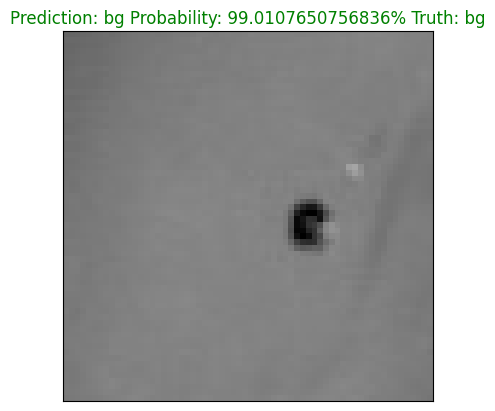

In [28]:
def plot_pred(pred_probs, lbls, imgs, n=50):
    pred_prob, true_label, image = pred_probs[n], lbls[n], imgs[n]
    pred_label = get_pred_label(pred_prob)
    true_label = get_pred_label(true_label)
    
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])
    print(pred_label)

    if pred_label == true_label:
        color = "green"
    else:
        color = "red"

    plt.title(f"Prediction: {pred_label} Probability: {np.max(pred_prob*100)}% Truth: {true_label}", color = color)


plot_pred(pred_probs=preds, lbls=val_labels, imgs=val_images, n=140)

Now we've got one function to visualize our model's top prediction.

Let's make another for our model's top ten predictions

The function will:
* the input from prediction probabilities array ✅
* ground truth array ✅
* an integer ✅
* Find the predicted label with `get_pred_label()` ✅
* Find the top 10:
 * Prediction probabilities✅
 * prediction probabilities indexes✅
 * prediction probability values✅
 * prediction labels✅
* plot the top 10 prediction values and labels, colour coding the true and false predictions ✅

In [29]:
def plot_pred_conf(pred_probs, lbls, n=1):
    pred_prob, true_label = pred_probs[n], lbls[n]
    pred_label = get_pred_label(pred_prob)
    true_label = get_pred_label(true_label)

    top_10_pred_indices = pred_prob.argsort()[-10:][::-1]
    top_10_pred_values = pred_prob[top_10_pred_indices]
    top_10_pred_labels = unique_colours[top_10_pred_indices]

    length = len(top_10_pred_labels)
    top_plot = plt.bar(np.arange(length), top_10_pred_values, color="grey")
    plt.xticks(np.arange(length), labels=top_10_pred_labels, rotation="vertical")
    
    if np.isin(true_label, top_10_pred_labels):
        top_plot[np.argmax(top_10_pred_labels) == true_label].set_color("green")
    else:
        pass

bg
bg
x
x
bg
x
bg
x
bg


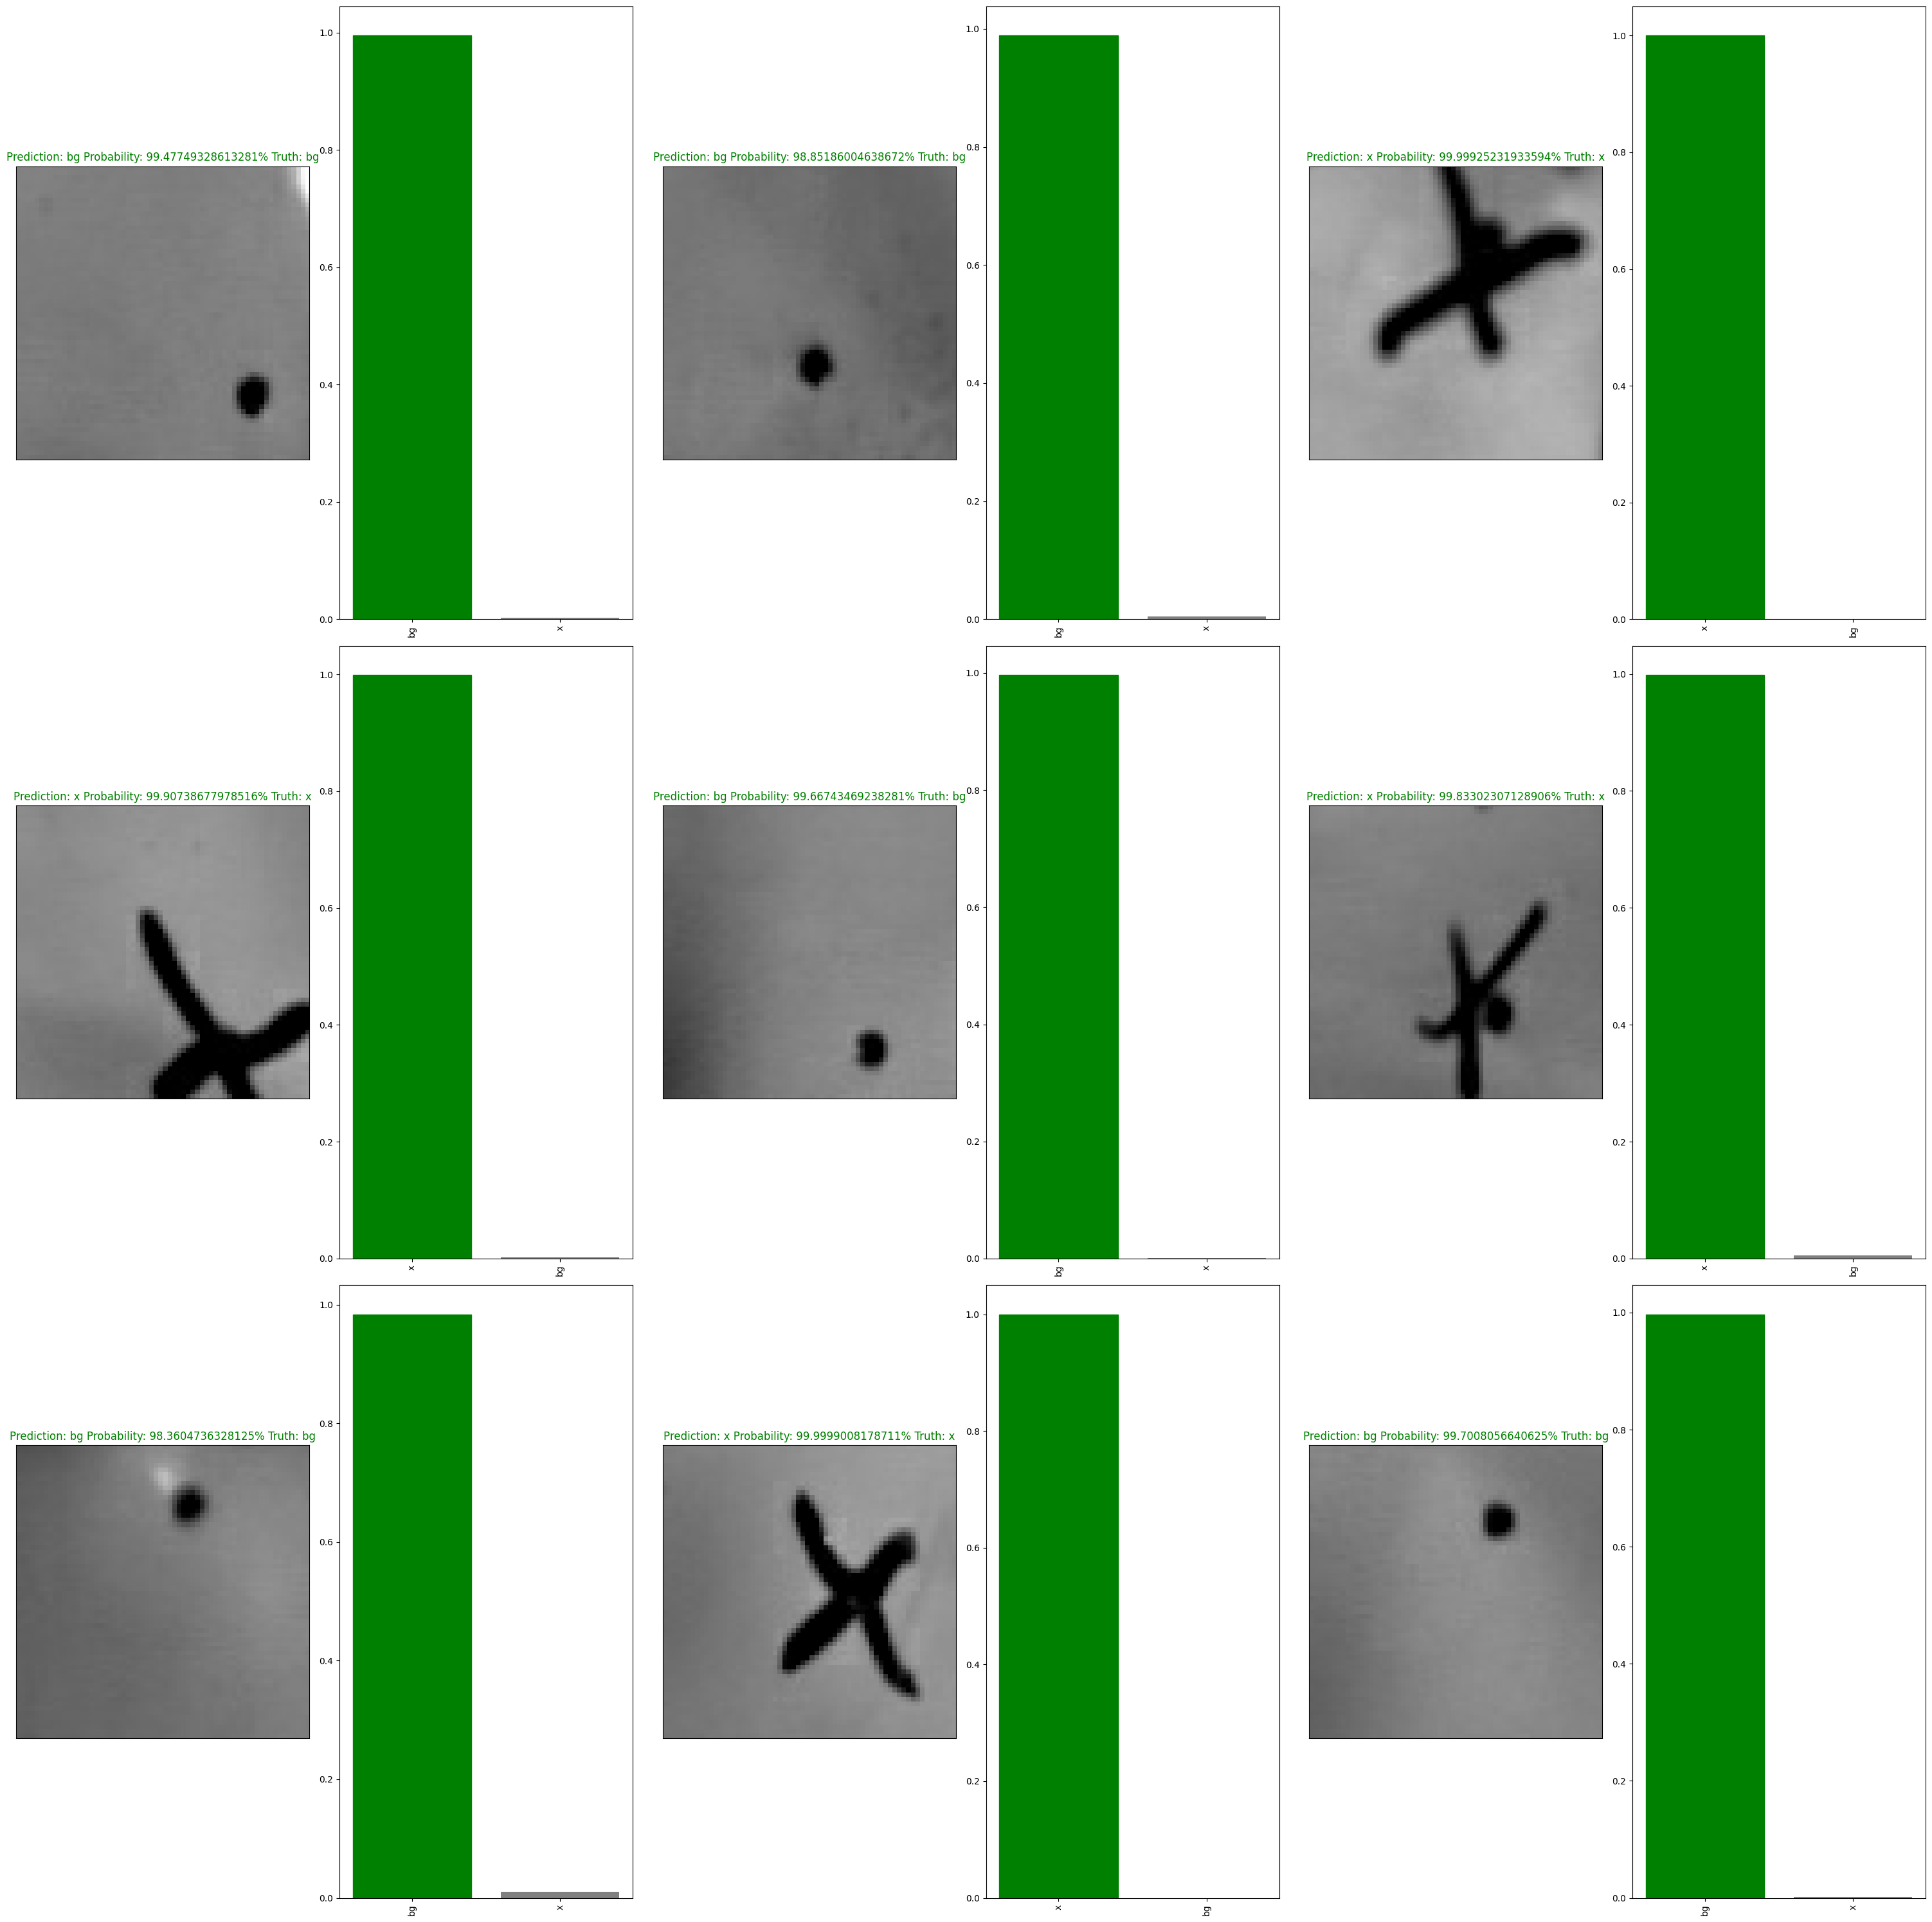

In [30]:
i_multiplier = 0
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize = (10*num_cols, 10*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, num_cols*2,2*i+1)

    plot_pred(preds, val_labels, val_images, n = i+i_multiplier)
    plt.subplot(num_rows, num_cols*2, 2*i+2)

    plot_pred_conf(preds, val_labels, n = i+i_multiplier)
    plt.tight_layout(h_pad = 1.0)
    plt.show

In [31]:
path = os.path.join(os.getcwd(), "model")
def save_model(model, suffix=None):
    model_path = path + "-" + suffix + ".h5"
    print(f"Saving model to {model_path}")
    model.save(model_path)

Now We've got functions to save a trained model (and load them) let's make sure they work

In [32]:
save_model(model, suffix="ttt")

Saving model to c:\Users\jribi\Projects\Python\tej4m-tic-tac-toe\models-ttt.h5


c:\Users\jribi\AppData\Local\Programs\Python\Python312\Lib\site-packages\tf_keras\src\engine\training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
